In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import mne
import matplotlib.pyplot as plt
import seaborn as sns
from mne_bids import BIDSPath, read_raw_bids

In [3]:
bids_root = "./nm000104"
subject = "01438774"
session = "1625258895"
bpath = BIDSPath(
    root=bids_root,
    subject=subject,
    session=session,
    task="typing",
    extension="bdf",
    datatype="emg",
    suffix="emg"
)
bpath.fpath

PosixPath('nm000104/sub-01438774/ses-1625258895/emg/sub-01438774_ses-1625258895_task-typing_emg.bdf')

In [4]:
raw = read_raw_bids(bpath)
raw

/var/folders/hs/jr1l53bx1m1gmsqm294qcpy40000gn/T/ipykernel_68901/214897811.py:1: RuntimeWarning: Unable to map the following column(s) to to MNE:
handedness: n/a
  raw = read_raw_bids(bpath)


<RawBDF | sub-01438774_ses-1625258895_task-typing_emg.bdf, 32 x 2058000 (1029.0 s), ~28 KiB, data not loaded>

In [5]:
raw.annotations

<Annotations | 4749 segments: keystroke_' (4), keystroke_, (7), ...>

In [6]:
annot_df = raw.annotations.to_data_frame()
annot_df.head()

,onset,duration,description,key,prompt_text
0,2025-11-12 08:51:15.272500,19.518,prompt,n/a,the quick brown fox jumps over a lazy dog\n
1,2025-11-12 08:51:17.757500,0.028,keystroke_t,t,n/a
2,2025-11-12 08:51:17.905500,0.075,keystroke_h,h,n/a
3,2025-11-12 08:51:17.995500,0.090,keystroke_e,e,n/a
4,2025-11-12 08:51:18.505499,0.090,keystroke_Key.space,Key.space,n/a


/var/folders/hs/jr1l53bx1m1gmsqm294qcpy40000gn/T/ipykernel_68901/3968951373.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


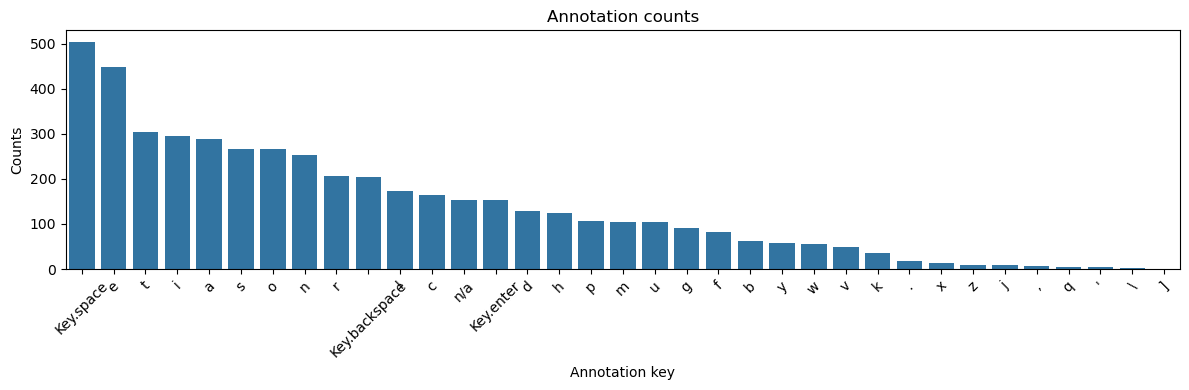

In [7]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.barplot(x=annot_df.key.value_counts().index, y=annot_df.key.value_counts().values, ax=ax)
ax.set_title("Annotation counts")
ax.set_ylabel("Counts")
ax.set_xlabel("Annotation key")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()

In [8]:
annot_df["description"] = annot_df.apply(
    lambda row: f"{row['description']}/{row['key']}" if row['key'] != 'n/a' else row['description'],
    axis=1
)
annot_df = annot_df.drop(columns=["key"])
annot_df.head()

,onset,duration,description,prompt_text
0,2025-11-12 08:51:15.272500,19.518,prompt,the quick brown fox jumps over a lazy dog\n
1,2025-11-12 08:51:17.757500,0.028,keystroke_t/t,n/a
2,2025-11-12 08:51:17.905500,0.075,keystroke_h/h,n/a
3,2025-11-12 08:51:17.995500,0.090,keystroke_e/e,n/a
4,2025-11-12 08:51:18.505499,0.090,keystroke_Key.space/Key.space,n/a


In [9]:
raw.annotations.description = annot_df["description"].values
events, event_id = mne.events_from_annotations(raw)

/var/folders/hs/jr1l53bx1m1gmsqm294qcpy40000gn/T/ipykernel_68901/4080106566.py:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  _ = mne.viz.plot_events(events, event_id=event_id, sfreq=raw.info["sfreq"])


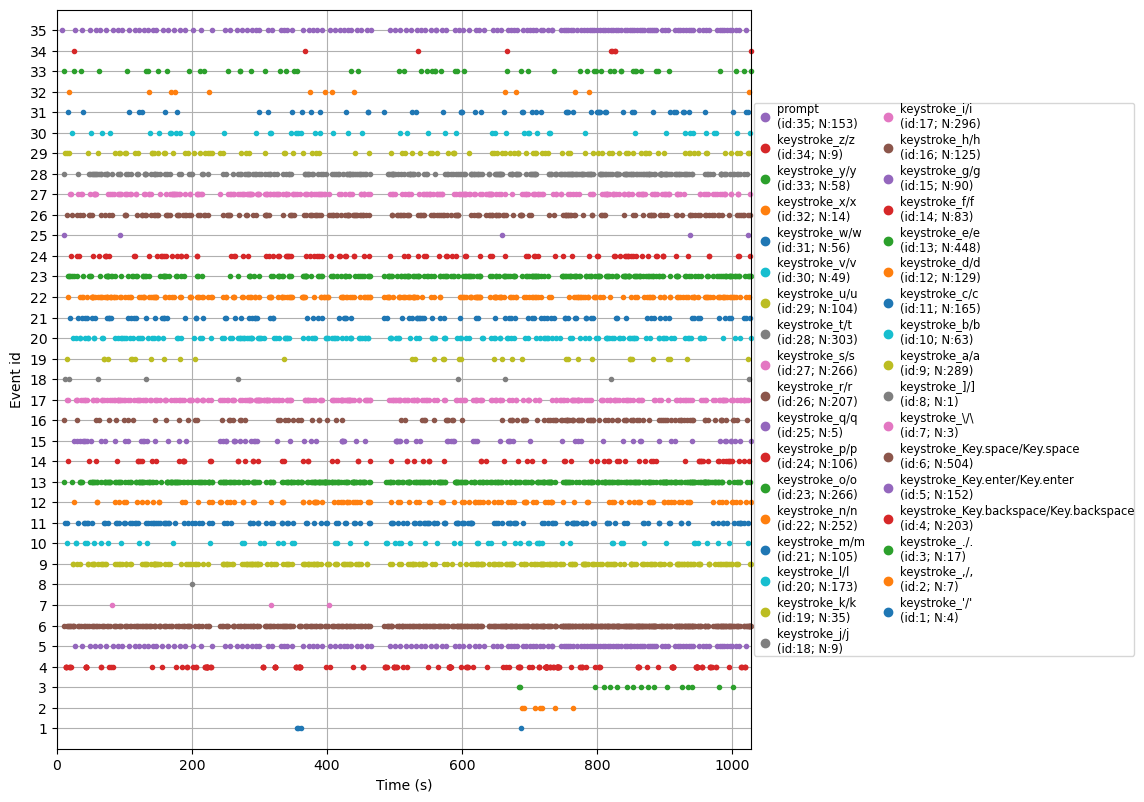

In [10]:
_ = mne.viz.plot_events(events, event_id=event_id, sfreq=raw.info["sfreq"])

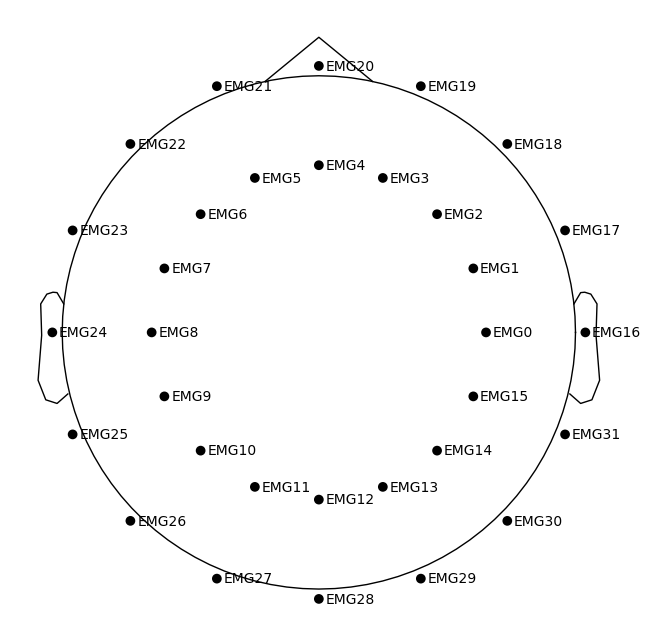

In [11]:
import numpy as np

def add_montage(raw):
    thetas = np.deg2rad(np.linspace(0, 360, 16, endpoint=False))
    xs = 50.0 * np.cos(thetas)
    ys = 50.0 * np.sin(thetas)
    zs = np.zeros_like(xs)
    elec_locs = np.vstack([xs, ys, zs]).T

    elec_locs_left = elec_locs + np.array([0, 0, 15.])
    elec_locs_right = elec_locs + np.array([0, 0, -15])
    elec_locs = np.vstack([elec_locs_left, elec_locs_right])
    ch_names = raw.ch_names
    dig_montage = mne.channels.make_dig_montage(
        ch_pos=dict(zip(ch_names, elec_locs / 1000)),
        rpa=(0, 0, 0.030),
        nasion=(0, 1, 0.030),
        lpa=(-1, 0, 0.030),
    )
    raw.set_montage(dig_montage)
    return raw


_ = add_montage(raw.copy().set_channel_types({ch: "eeg" for ch in raw.ch_names})).plot_sensors(show_names=True, ch_type="eeg")

In [12]:
raw.load_data()
picks = mne.pick_types(raw.info, emg=True, exclude="bads")
raw.filter(40., None, picks=picks)  # check that high-pass is not set properly in the measurement info

<RawBDF | sub-01438774_ses-1625258895_task-typing_emg.bdf, 32 x 2058000 (1029.0 s), ~502.5 MiB, data loaded>

/Users/agramfort/work/src/mne-python/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


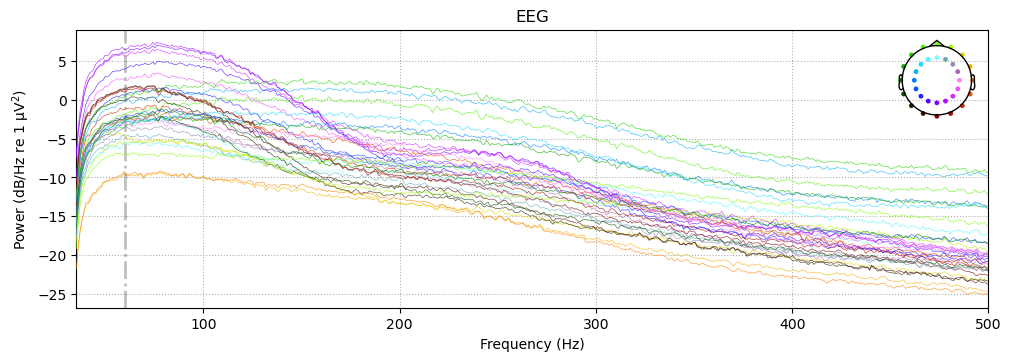

In [13]:
raw_ = add_montage(raw.copy().set_channel_types({ch: "eeg" for ch in raw.ch_names}))
_ = raw_.compute_psd(picks=picks, fmin=35, fmax=500).plot(picks=picks, spatial_colors=True)

In [14]:
# mne.viz.set_browser_backend("qt")
# _ = raw.plot(scalings={'emg': 1e6}, start=40, duration=5, n_channels=32)

In [15]:
raw_hilbert = raw_.copy().apply_hilbert(envelope=True, picks=picks).filter(1., 30., picks=picks)

In [16]:
epochs = mne.Epochs(
    raw_hilbert,
    events=events,
    event_id=event_id,
    tmin=-0.5,
    tmax=0.5,
    baseline=None,
    preload=False,
    picks=picks,
)

In [17]:
epochs["a"]

<Epochs | 289 events (good & bad), -0.5 – 0.5 s (baseline off), ~41 KiB, data not loaded,
 'keystroke_a/a': 289>

/var/folders/hs/jr1l53bx1m1gmsqm294qcpy40000gn/T/ipykernel_68901/1221037279.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


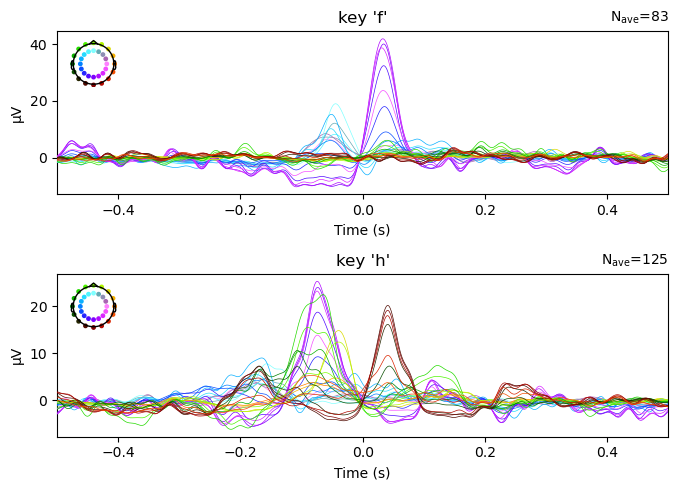

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
_ = epochs["f"].average(picks=picks).plot(spatial_colors=True, axes=ax1, show=False)
_ = epochs["h"].average(picks=picks).plot(spatial_colors=True, axes=ax2, show=False)
ax1.set_title("key 'f'")
ax2.set_title("key 'h'")
fig.tight_layout()